# Game of Life

## Introduction

__Solved by__: [avl](https://twitter.com/avlsec)

__Event__: DEFCON CTF Quals 2020: https://ctftime.org/event/994

__Challenge name__: Fountain OOO REliving (115 pts)

__Description__: We have found the fountain OOO RElive. By discovering its secrets, you will restart the game of life with a chance to do it all over again. This challenge is in memory of John Conway (26 December 1937 – 11 April 2020).

__File__: `fountain-ooo-relive`

## First analysis

We quickly realise `fountain-ooo-relive` is a MacroCell file representing a pattern that can be imported into the Golly software. Which corroborates the fact this challenge is a tribute to John Conway, a British mathematician famous for its cellular automation called "Game of Life".

Wikipedia is your friend: [https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life)

Link to software: [http://golly.sourceforge.net/](http://golly.sourceforge.net/)

In [1]:
with open('fountain-ooo-relive', 'r') as f:
    data = f.read()

In [15]:
data.splitlines()[:2]

['[M2]', '# GOOOlly its the Fountain OOO REliving']

After importing the file as a pattern into Golly, we obtain this:

![](../_images/golly.png)

... which very much looks like a computer architecture!

It turns out to be a minimalistic RISC architecture designed by a bunch of people who were challenged to make Tetris run on top of Golly. Here is a link to this epic thread: [https://codegolf.stackexchange.com/questions/11880/build-a-working-game-of-tetris-in-conways-game-of-life](https://codegolf.stackexchange.com/questions/11880/build-a-working-game-of-tetris-in-conways-game-of-life)

They basically built:
- a basic RISC architecture
- an assembly language
- an interpreter
- a higher-level language called Cogol

## Find the flag

Having read the above thread, it becomes obvious that the flag will be derived from instructions the organisers concealed into the memory of that custom computer.

But where are the instructions stored in memory? In the ROM! The instructions fetched from the ROM then update values of memory locations located in the RAM, after execution. 

The goal here is therefore to find instructions from the ROM.

The below figure shows where the ROM and the RAM are.

![](../_images/golly2.png)

If we zoom in on the ROM, we get...

![](../_images/ROM.png)

...a grid of automates that represents bits in memory. So we've got two different automates corresponding to 0s and 1s.

For example, if we zoom in even more, the automate representing "1" is ![](../_images/1.png)

## Let the fun begin

My approach here was:
- Use computer vision to detect patterns corresponding to 1s
- Create a corresponding matrix with the fetched 0s and 1s
- Parse the binary code to get assembly code
- Find the flag from the assembly

### Detect bits with OpenCV

The below code detects 1s and upload them in the `coords` array.

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_rgb = cv2.imread('../_images/ROM.png') # Screenshot of the ROM
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

template = cv2.imread('../_images/1.png',0) # Screenshot of a pattern coresponding to "1"

w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)

coords = []

for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    coords.append(pt)

cv2.imwrite('../_images/res.png',img_rgb)

And it gives:

![](../_images/res.png)

### Coordinates to matrix

We then convert the results stored in the `coords` array to a matrix.

In [24]:
n_cols = 116
n_lines = 59 # with the first one 
delta = 22
start_y = 6
start_x = 4

mat = np.zeros((59,116),int)

new_coords = []
for c in coords:
    x,y = c
    x = int((x - start_x)/delta)
    y = int((y - start_y)/delta)
    new_coords.append((x,y))
    mat[y][x] = 1

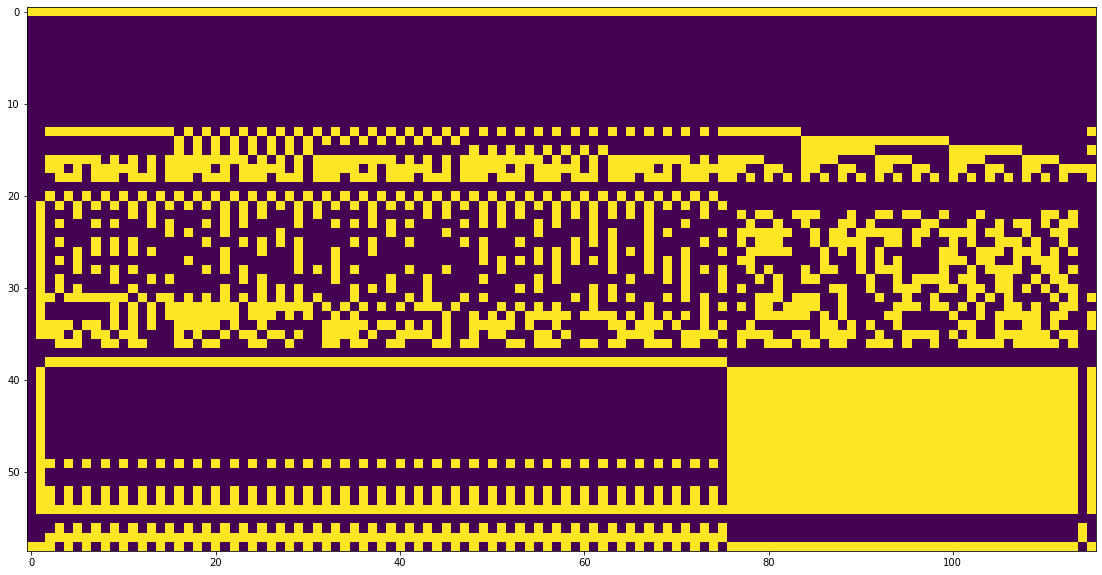

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(mat)

### Matrix to binary code instructions

Following the Stack Overflow thread, we can turn the matrix into instruction lines, which we store in the `code` variable. 

In [28]:
code = ""
for j in range(n_cols):
    for i in range(n_lines - 1):
        if mat[i+1][j] == 1:
            code += '1'
        else:
            code += '0'
    code += '\n'

In [27]:
code.splitlines()[:10]

['0000000000000000000000000000000000000000000000000000000001',
 '0000000000000000000011111111111111100011111111111111110001',
 '0000000000001001100100000000001001100100000000001001110011',
 '0000000000001001110010101010110001110100000000000000010110',
 '0000000000001001010100000000001001010100000000001001110011',
 '0000000000001001110011000111011000110100000000000000010110',
 '0000000000001001000100000000001001000100000000001001110011',
 '0000000000001001110010101101001001100100000000000000010110',
 '0000000000001000110100000000001000110100000000001001110011',
 '0000000000001001110010101101101111010100000000000000010110']

### Binary code to assembly instructions

"Assembly to binary code" has been implemented in the Python script: [https://github.com/QuestForTetris/QFT/blob/master/CreateROM.py](https://github.com/QuestForTetris/QFT/blob/master/CreateROM.py)

We reversed that script to get a "binary code to assembly" function. 

Assembly instructions are now stored in the `asm` variable.

In [30]:
from bitstring import BitArray

opcodes = {'0000': 'MNZ',
           '0001': 'MLZ',
           '0010': 'ADD',
           '0011': 'SUB',
           '0100': 'AND',
           '0101': 'OR',
           '0110': 'XOR',
           '0111': 'ANT',
           '1000': 'SL',
           '1001': 'SRL',
           '1010': 'SRA'}

modes = {'00': '',
         '01': 'A',
         '10': 'B',
         '11': 'C'}

def parse(code):
    out = ""
    count = 0 
    for l in code.splitlines()[::-1]:
        opcode = opcodes[l[-4:]]
        arg1 = l[18*2:-4]
        arg2 = l[18:18*2]
        arg3 = l[:18]
        mode1 = modes[arg1[:2]]
        arg1 = str(BitArray(bin=arg1[2:]).int)
        mode2 = modes[arg2[:2]]
        arg2 = str(BitArray(bin=arg2[2:]).int)
        mode3 = modes[arg3[:2]]
        arg3 = str(BitArray(bin=arg3[2:]).int)
        out += str(count) + '. ' + opcode + ' ' + mode1 + arg1 + ' ' + mode2 + arg2 + ' ' + mode3 + arg3 +'\n'
        count+=1
    return out

In [31]:
asm = parse(code)

In [32]:
print(asm)

0. MLZ -1 44 43
1. XOR 0 0 2
2. MLZ -1 25971 2
3. MLZ -1 14554 3
4. MLZ -1 22445 4
5. MLZ -1 25411 5
6. MLZ -1 3743 6
7. MLZ -1 13391 7
8. MLZ -1 12059 8
9. MLZ -1 2554 9
10. MLZ -1 15823 10
11. MLZ -1 5921 11
12. MLZ -1 18009 12
13. MLZ -1 14823 13
14. MLZ -1 4757 14
15. MLZ -1 7754 15
16. MLZ -1 22480 16
17. MLZ -1 8371 17
18. MLZ -1 12418 18
19. MLZ -1 22738 19
20. MLZ -1 16499 20
21. MLZ -1 7132 21
22. MLZ -1 22793 22
23. MLZ -1 22307 23
24. MLZ -1 12485 24
25. MLZ -1 7936 25
26. MLZ -1 26630 26
27. MLZ -1 15483 27
28. MLZ -1 6471 28
29. MLZ -1 1806 29
30. MLZ -1 22705 30
31. MLZ -1 25019 31
32. MLZ -1 16442 32
33. MLZ -1 5145 33
34. MLZ -1 15593 34
35. MLZ -1 23867 35
36. MLZ -1 23738 36
37. MLZ -1 14086 37
38. MLZ -1 23123 38
39. MLZ -1 0 39
40. XOR A1 -27179 39
41. SUB A39 A2 2
42. XOR A1 -14018 39
43. SUB A39 A3 3
44. XOR A1 -22549 39
45. SUB A39 A4 4
46. XOR A1 -27735 39
47. SUB A39 A5 5
48. XOR A1 -225 39
49. SUB A39 A6 6
50. XOR A1 -15190 39
51. SUB A39 A7 7
52. XOR A1 -8339

### Interpreter

An interpreter exists: [http://play.starmaninnovations.com/qftasm/](http://play.starmaninnovations.com/qftasm/)

But the code is easy enough to be analysed quickly:
* The `MLZ -1 [n] [addr]` instructions set the `addr` value to the number `n`.
* Addresses 2 to 38 contain values that then get updated using `XOR` and `SUB` methods.
* Two other variables located respectively in addresses 1 and 39 are being used to perform the updates.
* Value at address 39 is known but not at address 1.

In [35]:
def interpreter(asm, addr1):
    init = []
    xored = []
    for l in asm.splitlines()[2:39]:
        init.append(int(l.split()[3]))
    for l in asm.splitlines()[40:-2:2]:
        xored.append(int(l.split()[3]))
    return [(addr1^v)-u+32768 for u,v in zip(init,xored)]

### Solving the challenge

* We know that the flag starts with `OOO`.
* As address 1 is unknown, the last step here is to try out different possibilities for that address (bruteforce) until we find the ASCII decimal code to the `O` character in the 3 first addresses containing the flag (2, 3 and 4).

In [36]:
def solve(asm):
    for i in range(37000):
        l = interpreter(asm, i)
        if l[:3] == [79,79,79]:
            return "".join([chr(u) for u in l])
    return 'Not found'

In [37]:
solve(asm)

'OOO{in_this_life___youre_on_your_own}'